# Simulate Analog CIM Compute SNR

Kentaro Yoshioka

Simple Analog CIM analyzing script, reporting SQNR and CSNR. The calculation should be similar to the ComputationSNR proposed in [ref].

ref: Gonugondla et al. - 2020 - Fundamental Limits on the Precision of In-memory Architectures

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def quantize_k(r_i, k, noise=0):
    # r_i: input float
    # k: quantize bit
    # noise: ADC noise [proportional to ADC LSB]
    # r_o: quantized + noise output
    scale = 2**(k-1)
    
    # set noise
    rd = np.random.randn(1) * noise
    #print(rd, scale*r_i)
    r_o = (np.round( scale * r_i + rd)) / scale # add noise then round
    return r_o

def quantize_d(r_i, k):
    # r_i: input float
    # k: quantized bit
    # return: int quantized value
    scale = 2**(k-1)
    r_o = np.round( scale * r_i )
    return r_o

# Quantize and make a binary representation
def quantize_mod(r_i, k):
    # get sign
    sign = np.clip(np.array(r_i)*10e6, -1, 1)
    # rest
    rest = np.abs(r_i)   
    # normalize
    if np.max(rest)>1:
        rest = rest / 2**(k-1)
    
    # Quant.
    inds = quantize_d(rest, k)   
    out = np.zeros([len(inds), k])
    
    # to binary
    for i,d in enumerate(inds):
        if d > 2**(k-1)-1:
            d = 2**(k-1)-1

        # 2's complements
        signed_d = int(sign[i]*d)
        d_bin = bin(signed_d & 2**k-1) # 2の補数にするには最大値とANDを取る

        # fill with zeros
        out[i] = np.array(list(d_bin.split("b")[-1].zfill(k))).astype("int")
    return out

In [6]:
np.unique(quantize_k(np.arange(-1,1,0.1), 4, noise=0))

array([-1.   , -0.875, -0.75 , -0.625, -0.5  , -0.375, -0.25 , -0.125,
       -0.   ,  0.125,  0.25 ,  0.375,  0.5  ,  0.625,  0.75 ,  0.875])

In [7]:
sqnrs = []

N = 64
M = int(32*1024/N)

for k in range(3,5):
    sig = []
    error = []
    for _ in range(M):
        a = (np.random.rand(N))*2**k
        a_bin = quantize_mod(a/2**k, k+1) # uint
        b = (np.random.rand(N)-0.5)*2**k
        b_bin = quantize_mod(b/2**(k-1), k)

        out = 0
        # multiply by nest
        for i in range(k+1):
            weight = 2**(k-i) # aはuintとする
            for ii in range(k):
                sign = -1 if ii==0 else 1 # 2の補数ではMSBが負のため
                weight2 = 2**(k-1-ii)
                res = np.sum(a_bin[:,i]*b_bin[:,ii]*weight*weight2*sign)
                out += res
            
        # ideal digital computation
        digital = np.dot(a, b)
        
        # calc errors
        sig.append(digital**2)
        error.append((digital-out)**2)

    # compute sqnr
    sqnr = np.log10(np.sqrt(np.sum(np.array(sig))/np.sum(np.array(error))))*20
    sqnrs.append(sqnr)
sqnrs

[14.711538509472014, 21.440838816232862]

# Add ADC quantization effects

[7.272911389258212, 12.35569839310678, 13.859575893873819, 15.391117287531166, 15.683528993664513, 16.895734769935174, 16.512675321559705, 16.417438133486154, 15.163145523887573]
[5.812005975004362, 11.292752173685534, 12.74432199297754, 12.29097577713733, 12.411925917586897, 13.878661030799215, 13.596599320314333, 13.967742943764272, 14.283764015576592]
[5.219294345373027, 10.87118454061838, 8.93824817517701, 9.201907179705598, 10.381240413430726, 10.218025221879444, 12.514478659590766, 12.111376461198498, 10.16284012262628]
[4.067824008646763, 8.693290421375764, 5.69069916452189, 8.978392588823835, 10.437576716923914, 7.333759468459102, 8.266139031440268, 8.331211662355047, 10.30344771168153]


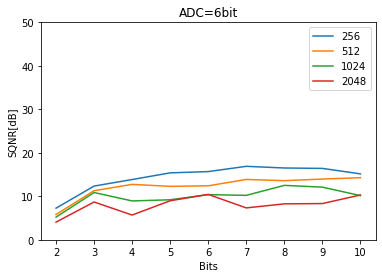

[6.550585496014447, 14.185018205757903, 17.69705512535384, 20.82767234446426, 21.147546732034407, 20.86137802343764, 21.27969019244101, 20.31239598389223, 20.95738512935788]
[6.496447934675428, 13.92117234550856, 17.16464429740256, 18.52407684130497, 17.222338684737355, 20.155341520439435, 19.078988342149913, 18.65344373634873, 19.57069006440178]
[6.529454573240122, 12.71349743194756, 15.432831597649566, 16.668416033861075, 18.279684380210345, 18.665801267964312, 16.85632029283831, 15.713733583016374, 15.684849912489904]
[6.371133346953748, 10.021174672892748, 15.629435876422711, 12.101764182358654, 13.699398521359225, 14.39691449085307, 14.887355831305417, 11.58176220679678, 15.765864342548566]


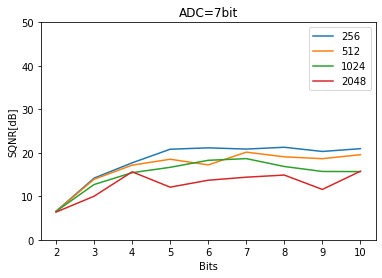

[7.194354358171841, 15.04733620092702, 22.540277228308362, 28.041876887523888, 34.69494225199908, 39.825391445439465, 46.582410337768216, 52.661146714933096, 60.09503165420141]
[7.099659036380111, 13.340855640711071, 19.075258588521965, 23.10102172572023, 25.180325941938058, 23.61749796485261, 23.344680959863602, 22.977025993305134, 23.474755856288184]
[7.5432075855635015, 12.876211114694398, 18.275626680140554, 22.802125442379563, 21.345845388468227, 24.214084056043298, 22.324208908618687, 21.863157139635128, 20.812220551570697]
[7.309587077564742, 12.221152126613571, 18.20324754134176, 19.552985794602165, 20.21993043954199, 20.373284656283275, 19.194094745712714, 21.447304749802335, 17.820359713251943]


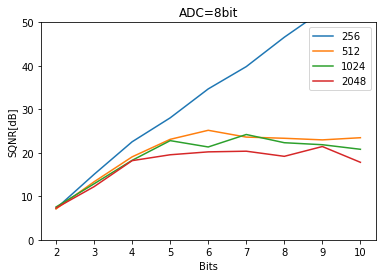

[7.631375713928107, 14.708824516629077, 21.954572387011538, 28.716610738450807, 35.79768740687503, 41.290869556017455, 48.120009257125524, 53.25780110934695, 59.962887985672204]
[6.285157319610866, 15.371751774520604, 21.302500481097468, 30.667503351684985, 35.128404520548514, 42.189963634258405, 46.92708054687225, 52.56451811981379, 59.21780210150505]
[7.1620567976834915, 12.592626727860583, 21.21972018112704, 23.762745074063467, 27.829588570168298, 28.760033461105596, 27.347409155230174, 24.49822122870568, 26.230682768179708]
[7.011234236633973, 14.269939582078585, 20.464390370004807, 25.367220994626052, 24.145617391149564, 24.853760134512527, 22.760233935609563, 23.24513354733127, 24.75683193054978]


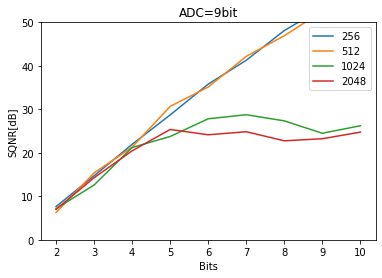

[7.275116187261884, 14.11918088782282, 22.045707073568742, 28.66043764973748, 35.12032698625455, 41.200122529287164, 46.8578624104297, 53.09158788876137, 59.134948417131184]
[7.534708529123407, 14.827059181370103, 22.352715132579828, 27.965893194341117, 35.080005446669944, 40.84636201421803, 47.79501867953256, 53.70706155739338, 59.59768288515437]
[6.357126894759641, 15.148958948408694, 20.135388485661988, 28.788572682733587, 34.608760510640685, 41.72538544065519, 45.74535472719597, 52.9263958845166, 57.14923832313428]
[8.32442947783151, 13.329500614782573, 21.73145133854494, 25.76197281861004, 27.943284972846932, 29.037097442786248, 31.496422364195652, 29.054612682006265, 31.24934203802813]


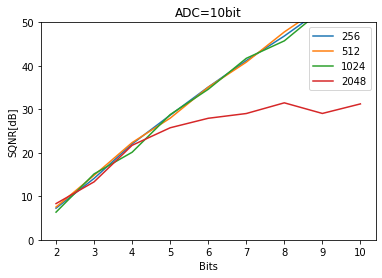

[7.002111235558751, 14.489622951052699, 21.92034358466818, 28.230865426350555, 34.81235097798917, 39.48315736121591, 47.13735272002323, 52.55812952449411, 58.959334742692505]
[7.489997285763748, 15.185291142077627, 22.356570294745566, 28.394897011839024, 34.97917357836515, 40.93529708799811, 46.611134344176925, 53.36935668380033, 58.093166707153465]
[7.213030361205398, 15.727929832165694, 21.13700789738823, 27.273269312567976, 35.57058395359252, 41.73512989441211, 46.15895984536288, 53.00176714125077, 61.488960093002305]
[7.801655323128114, 13.579505779651114, 25.167567102197026, 28.8843921489362, 33.937497307590014, 42.02252513640903, 46.766308069406605, 51.27643144828765, 60.86795130683698]


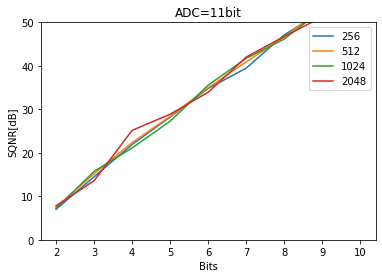

In [17]:
sqnrs_forbits = []
for ADCBIT in [6,7,8,9,10,11]:
    sqnrs = []
    for N in [256,512,1024,2048]:
        sqnrs_adc = []
        M = int(32*2048/N)
        adcs_raw = []
        adcs = []
        for k in range(2,11):
            sig = []
            error = []
            for _ in range(M):
                a = (np.random.rand(N))*2**k
                a_bin = quantize_mod(a/2**k, k+1) # uint
                b = (np.random.rand(N)-0.5)*2**k
                b_bin = quantize_mod(b/2**(k-1), k)

                out = 0
                # multiply by nest
                for i in range(k+1):
                    weight = 2**(k-i) # aはuintとする
                    for ii in range(k):
                        sign = -1 if ii==0 else 1 # 2の補数ではMSBが負のため
                        weight2 = 2**(k-1-ii)
                        # CIM計算
                        adc = np.sum(a_bin[:,i]*b_bin[:,ii])
                        adcs_raw.append(adc)
                        # ADC変換
                        adc_q = quantize_k(np.array(adc)/N, ADCBIT+1)*N # full scale is 2048
                        adcs.append(adc_q)
                        # 重み付けしaccumulate
                        res = adc_q*weight*weight2*sign
                        out += res

                # ideal digital computation
                digital = np.dot(a, b)

                # calc errors
                sig.append(digital**2)
                error.append((digital-out)**2)

            # compute sqnr
            sqnr = np.log10(np.sqrt(np.sum(np.array(sig))/np.sum(np.array(error))))*20
            sqnrs_adc.append(sqnr)
        sqnrs.append(sqnrs_adc)
        print(sqnrs_adc)
        
    # plot results
    plt.ylim(0,50)
    plt.plot(range(2,11), sqnrs[0], label="256")
    plt.plot(range(2,11), sqnrs[1], label="512")
    plt.plot(range(2,11), sqnrs[2], label="1024")
    plt.plot(range(2,11), sqnrs[3], label="2048")
    plt.xlabel("Bits")
    plt.ylabel("SQNR[dB]")
    plt.title("ADC={}bit".format(ADCBIT))
    plt.legend()
    plt.show()
    sqnrs_forbits.append(sqnrs)

# Replicate Jia, JSSC 2020
Next, we replicate the results in Jia, "A Programmable Heterogeneous Microprocessor Based on Bit-Scalable In-Memory Computing" JSSC 2020.

![](figs/sqnr_paper.png)

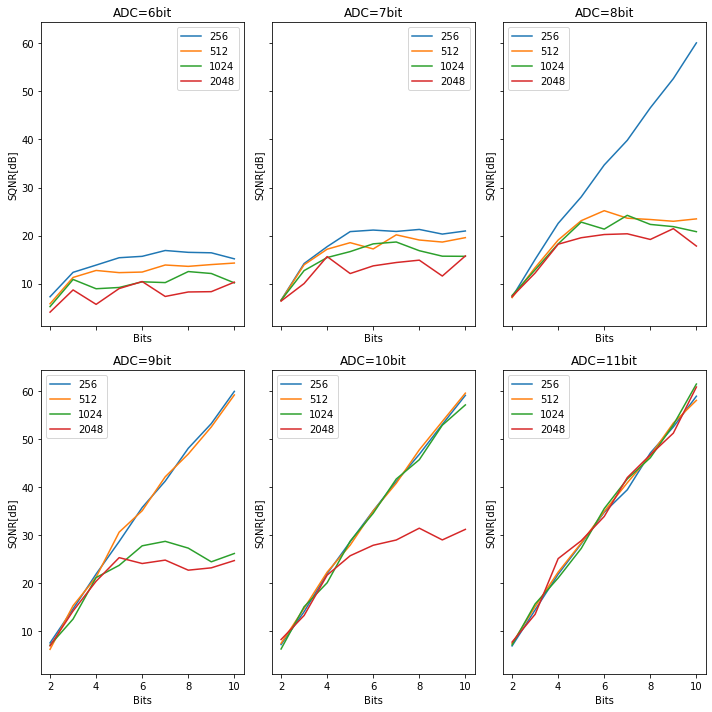

In [18]:
fig, axes = plt.subplots(2, 3, tight_layout=True, sharex=True, sharey=True, figsize=(10,10))
axs = plt.gcf().get_axes()

for i,ax in enumerate(axs):
    # 現在の軸を変更
    plt.axes(ax)
    # plot results
    plt.plot(range(2,11), sqnrs_forbits[i][0], label="256")
    plt.plot(range(2,11), sqnrs_forbits[i][1], label="512")
    plt.plot(range(2,11), sqnrs_forbits[i][2], label="1024")
    plt.plot(range(2,11), sqnrs_forbits[i][3], label="2048")
    plt.legend()
    plt.xlabel("Bits")
    plt.ylabel("SQNR[dB]")
    plt.title("ADC={}bit".format(i+6))
 

### Plot only Array=1024, which is reported in [Jia]

[5.219294345373027, 10.87118454061838, 8.93824817517701, 9.201907179705598, 10.381240413430726, 10.218025221879444, 12.514478659590766, 12.111376461198498, 10.16284012262628]
[6.529454573240122, 12.71349743194756, 15.432831597649566, 16.668416033861075, 18.279684380210345, 18.665801267964312, 16.85632029283831, 15.713733583016374, 15.684849912489904]
[7.5432075855635015, 12.876211114694398, 18.275626680140554, 22.802125442379563, 21.345845388468227, 24.214084056043298, 22.324208908618687, 21.863157139635128, 20.812220551570697]
[7.1620567976834915, 12.592626727860583, 21.21972018112704, 23.762745074063467, 27.829588570168298, 28.760033461105596, 27.347409155230174, 24.49822122870568, 26.230682768179708]
[6.357126894759641, 15.148958948408694, 20.135388485661988, 28.788572682733587, 34.608760510640685, 41.72538544065519, 45.74535472719597, 52.9263958845166, 57.14923832313428]
[7.213030361205398, 15.727929832165694, 21.13700789738823, 27.273269312567976, 35.57058395359252, 41.73512989441

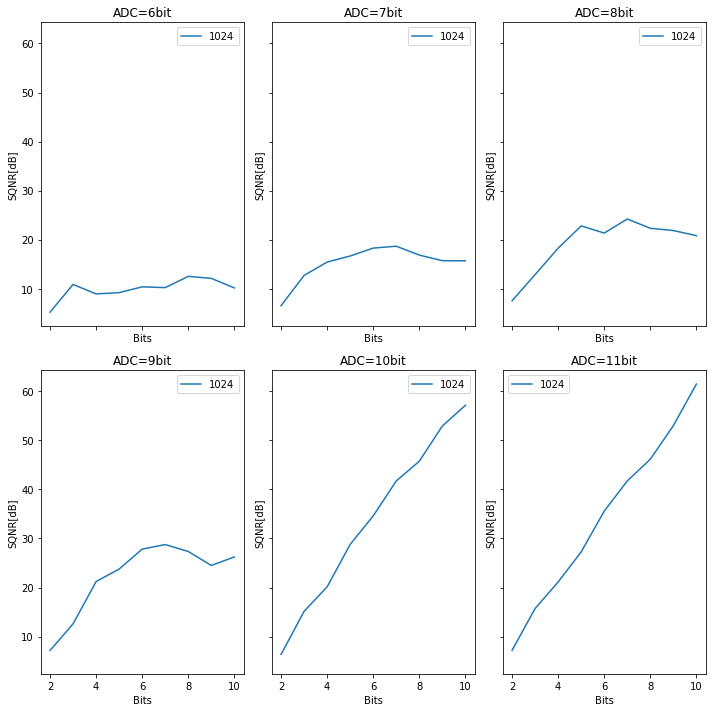

In [19]:
fig, axes = plt.subplots(2, 3, tight_layout=True, sharex=True, sharey=True, figsize=(10,10))
axs = plt.gcf().get_axes()

for i,ax in enumerate(axs):
    # 現在の軸を変更
    plt.axes(ax)
    # plot results
    #plt.plot(range(2,11), sqnrs_forbits[i][0], label="256")
    #plt.plot(range(2,11), sqnrs_forbits[i][1], label="512")
    plt.plot(range(2,11), sqnrs_forbits[i][2], label="1024")
    #plt.plot(range(2,11), sqnrs_forbits[i][3], label="2048")
    plt.legend()
    plt.xlabel("Bits")
    plt.ylabel("SQNR[dB]")
    plt.title("ADC={}bit".format(i+6))
    print(sqnrs_forbits[i][2])

# Now, simulate with analog noise

In [14]:
def get_csnr(N=1024, noise_list = [0.4,], M=256, ADCRANGE=range(8,13)):
    """
    Calculate and plot CSNR for different ADC bit resolutions and noise levels.
    
    This function simulates a CIM process with quantization, calculates the CSNR.

    Parameters:
    - N (int): Number of CIM rows. Default is 1024.
    - noise_list (list): List of noise levels to simulate. Note that the unit is the ADC LSB being simulated. Default is [0.4] (LSB).
    - M (int): Number of simulation iterations for each configuration. Default is 256.
    - ADCRANGE (range): Range of ADC bit resolutions to simulate. Default is range(8, 13).

    Returns:
    - list: List of SQNR values for each configuration.

    The function performs the following steps:
    1. Iterate through different ADC bit resolutions.
    2. For each noise level:
        a. Generate random input signals.
        b. Perform CIM with quantization and noise.
        c. Calculate ideal digital computation results.
        d. Compute SQNR based on error between ideal and simulated results.
    3. Plot CSNR vs. input bit width for each ADC resolution and noise level.
    """
    for ADCBIT in ADCRANGE:
        csnrs = []
        print("BIT:", ADCBIT)
        
        for noise in noise_list:    
            csnrs_adc = [] 
            adcs_raw = []
            adcs = []
            for k in range(2,9):
                sig = []
                error = []
                for _ in range(M):
                    a = np.abs((np.random.rand(N))*2**k)
                    a_bin = quantize_mod(a/2**k, k+1) # uint
                    b = (np.random.rand(N)-0.5)*2**k
                    b_bin = quantize_mod(b/2**(k-1), k)

                    out = 0
                    out2 = 0
                    # multiply by nest
                    for i in range(k+1):
                        weight = 2**(k-i) # aはuintとする
                        for ii in range(k):
                            if ii==0:
                                sign = np.clip(b*1000, -1, 1)
                            else:
                                sign = np.ones_like(b_bin[:,ii])
                            weight2 = 2**(k-1-ii)
                            # CIM
                            adc = np.sum(a_bin[:,i]*b_bin[:,ii]*sign)
                            
                            # ADC
                            adc_q0 = quantize_k(np.array(adc)/N*2, ADCBIT+1)*N/2
                            adc_q = quantize_k(np.array(adc)/N*2, ADCBIT+1, noise)*N/2
                            if ii>1:
                                adcs_raw.append(adc_q)
                            
                            adcs.append(adc_q)
                            # Accumulate with weightings
                            res = adc_q*weight*weight2
                            out += res
                            res2 = adc_q0*weight*weight2
                            out2 += res2

                    # ideal digital computation
                    digital = np.dot(a, b)

                    # calc errors
                    sig.append(digital**2)
                    error.append((digital-out2)**2+(out2-out)**2)

                # compute csnr
                csnr = np.log10(np.sqrt(np.sum(np.array(sig))/np.sum(np.array(error))))*20
                csnrs_adc.append(csnr)
                
            csnrs.append(csnrs_adc)
            print(noise, csnrs_adc)
            print(np.min(np.array(adcs_raw)), np.max(np.array(adcs_raw)))
            
        # plot results
        for i, n in enumerate(noise_list):
            plt.plot(range(2,9), csnrs[i], label="ADC:{} noise={}LSB".format(ADCBIT, n))
    plt.xlabel("I/W Bit Precision")
    plt.ylabel("CSNR[dB]")
    plt.title("N={}".format(N))
    plt.legend()
    plt.show()
    return csnrs

BIT: 10
0.3 [7.203464257647276, 14.480453897958894, 21.51888546910606, 28.560041997860488, 31.588720667050808, 33.38634556898746, 34.748249319476884]
-0.5 406.0
0.6 [6.794104204987084, 14.727562123996234, 21.142711451084537, 25.210412163008517, 27.20461643826235, 27.50647490866992, 28.31062851828139]
-1.0 403.0
0.9 [7.017719149650047, 14.232597547444561, 20.372637406042987, 22.86100231375177, 24.67530602650286, 23.90367666276651, 23.949407330730224]
-1.5 402.5


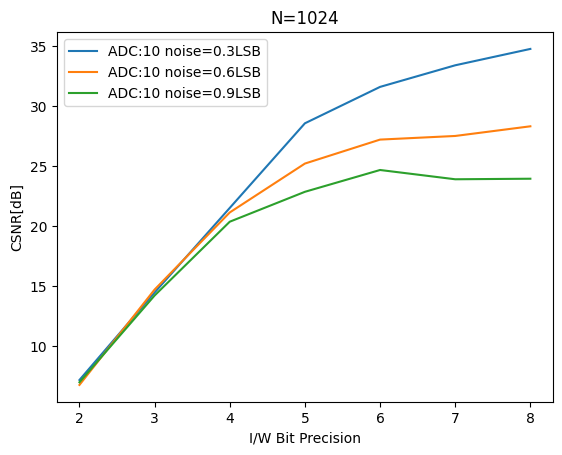

[[7.203464257647276,
  14.480453897958894,
  21.51888546910606,
  28.560041997860488,
  31.588720667050808,
  33.38634556898746,
  34.748249319476884],
 [6.794104204987084,
  14.727562123996234,
  21.142711451084537,
  25.210412163008517,
  27.20461643826235,
  27.50647490866992,
  28.31062851828139],
 [7.017719149650047,
  14.232597547444561,
  20.372637406042987,
  22.86100231375177,
  24.67530602650286,
  23.90367666276651,
  23.949407330730224]]

In [20]:
csnrs = get_csnr(1024, M=256, ADCRANGE=[10], noise_list=[0.3, 0.6, 0.9])
csnrs

BIT: 8
0.4 [6.4614152822191775, 12.971506562232316, 16.01542204781209, 17.071572227030877, 17.780416901171836, 17.982303746165382, 16.966863651170613]
-2.0 406.0
BIT: 9
0.4 [7.1616565323345815, 14.995580721412196, 20.41332773896583, 22.517778727181494, 25.062780453782953, 24.40737584723863, 25.062816962473015]
-1.0 413.0
BIT: 10
0.4 [7.660456218275967, 15.508344932848225, 20.62108955564781, 26.512162221598693, 28.514104319308217, 30.154554673450615, 31.248781327010768]
-0.5 407.0


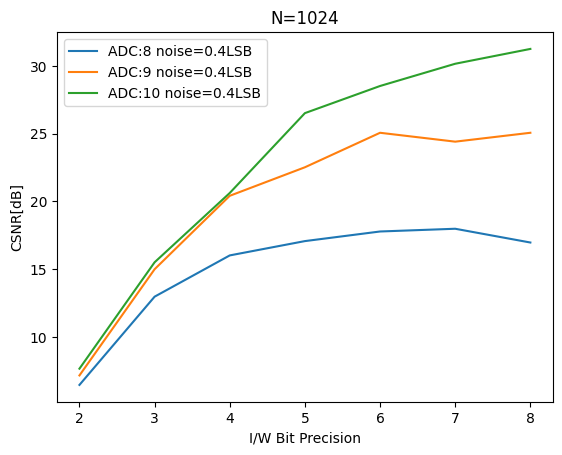

[[7.660456218275967,
  15.508344932848225,
  20.62108955564781,
  26.512162221598693,
  28.514104319308217,
  30.154554673450615,
  31.248781327010768]]

In [16]:
get_csnr(1024, M=256, noise_list=[0.4], ADCRANGE=range(8,11))